In [2]:
import json
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

import seaborn as sns
plt.style.use('seaborn')

import numpy as np
from scipy.stats.mstats import mquantiles
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [3]:
#read csv file
df = pd.read_csv('data/Motor_Vehicle_Collisions_-_Crashes.csv', low_memory=False)

We transform the column titles and show the informations in the imported dataset.

In [4]:
df.columns = [c.replace(' ', '_') for c in df.columns]
print('Get information on the input data' + '\n\n')
print(df.info())

Get information on the input data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754424 entries, 0 to 1754423
Data columns (total 29 columns):
CRASH_DATE                       object
CRASH_TIME                       object
BOROUGH                          object
ZIP_CODE                         object
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                         object
ON_STREET_NAME                   object
CROSS_STREET_NAME                object
OFF_STREET_NAME                  object
NUMBER_OF_PERSONS_INJURED        float64
NUMBER_OF_PERSONS_KILLED         float64
NUMBER_OF_PEDESTRIANS_INJURED    int64
NUMBER_OF_PEDESTRIANS_KILLED     int64
NUMBER_OF_CYCLIST_INJURED        int64
NUMBER_OF_CYCLIST_KILLED         int64
NUMBER_OF_MOTORIST_INJURED       int64
NUMBER_OF_MOTORIST_KILLED        int64
CONTRIBUTING_FACTOR_VEHICLE_1    object
CONTRIBUTING_FACTOR_VEHICLE_2    object
CONTRIBUTING_FACTOR_VEHICLE_3    object
CONTRIBUTING_

We want to find elements with no coordinate data (no longitude and latitude data) -> invalid data points.

We also show the min and max values of the coordinate data to find further invalid data points.


Furthermore we are looking at the borough data. To find data points without borough information.


In [5]:
dfNoCoordinates = df[(df.LATITUDE == 0) & (df.LONGITUDE == 0)]

#get min and max values of longitude and latitude data to evaluate the correctness of the data
BBoxDf = (df.LONGITUDE.min(),   df.LONGITUDE.max(), df.LATITUDE.min(), df.LATITUDE.max())

#print number of unique boroughs eg how many accident data points occur in each borough, print number of invalid data points, print min and max coordinate values
print('number of unique boroughs and number of data points per borough')
print('number of invalid data points included'+ '\n\n')

print(df.BOROUGH.value_counts(dropna=False))

print('There are: ' + str(len(dfNoCoordinates)) + ' data points without lat and long data.')

print('valuation of min/max values of lat and long data')
print('there are data points with missing lat and long data:')

print(BBoxDf)

number of unique boroughs and number of data points per borough
number of invalid data points included


NaN              538571
BROOKLYN         380845
QUEENS           325564
MANHATTAN        283592
BRONX            174272
STATEN ISLAND     51580
Name: BOROUGH, dtype: int64
There are: 1280 data points without lat and long data.
valuation of min/max values of lat and long data
there are data points with missing lat and long data:
(-201.35998999999998, 0.0, 0.0, 43.344444)


We drop the elements without borough information.

In [6]:
df = df.dropna(subset=['BOROUGH'])

#find elements with no coordinate data (no longitude and latitude data) -> invalid data points
dfBoroughNoCoordinates = df[(df.LATITUDE == 0) & (df.LONGITUDE == 0) ]

#get min and max values of longitude and latitude data to evaluate the correctness of the data
BBoxTrimed = (df.LONGITUDE.min(),   df.LONGITUDE.max(), df.LATITUDE.min(), df.LATITUDE.max())

#print number of unique boroughs eg how many accident data points occur in each borough, print number of invalid data points, print min and max coordinate values
print('number of unique boroughs and number of data points per borough after transformation of dataframe' + '\n\n' )
print(df.BOROUGH.value_counts())

print('There are still: ' + str(len(dfBoroughNoCoordinates)) + ' data points without lat and long data.')

print('valuation of min/max values of lat and long data')
print('there are data points with missing lat and long data:')
print(BBoxTrimed)

number of unique boroughs and number of data points per borough after transformation of dataframe


BROOKLYN         380845
QUEENS           325564
MANHATTAN        283592
BRONX            174272
STATEN ISLAND     51580
Name: BOROUGH, dtype: int64
There are still: 984 data points without lat and long data.
valuation of min/max values of lat and long data
there are data points with missing lat and long data:
(-74.25453159999999, 0.0, 0.0, 41.12615)


For the rest of the exercise, we drop all the invalid data points. For further simplification, we drop every data point without an information on the corresponding borough and without long and lat data.

We only look at the data with important information in regads to our problem. We drop the incomplete data points.



In [7]:
df = df[['CRASH_DATE','BOROUGH', 'LATITUDE', 'LONGITUDE', 'NUMBER_OF_CYCLIST_INJURED','NUMBER_OF_CYCLIST_KILLED']]
df = df[(df.LATITUDE != 0) | (df.LONGITUDE != 0)]

print(df.describe())

           LATITUDE     LONGITUDE  NUMBER_OF_CYCLIST_INJURED  \
count  1.183425e+06  1.183425e+06               1.214869e+06   
mean   4.072265e+01 -7.392213e+01               2.591144e-02   
std    7.845831e-02  8.288228e-02               1.603461e-01   
min    4.049895e+01 -7.425453e+01               0.000000e+00   
25%    4.066752e+01 -7.397766e+01               0.000000e+00   
50%    4.071995e+01 -7.393131e+01               0.000000e+00   
75%    4.076591e+01 -7.387150e+01               0.000000e+00   
max    4.112615e+01 -7.370055e+01               4.000000e+00   

       NUMBER_OF_CYCLIST_KILLED  
count              1.214869e+06  
mean               1.020686e-04  
std                1.018354e-02  
min                0.000000e+00  
25%                0.000000e+00  
50%                0.000000e+00  
75%                0.000000e+00  
max                2.000000e+00  


We look at the unique values of injured/killed cyclists -> we evaluate if there are any invalid data points (NaN values) to replace the data.

We create a new dataframe with only the accident data points, where cyclists were injured/killed. For complexity reasons this reduces the number of data points. To reduce the runtime. 

In [8]:

print(df.NUMBER_OF_CYCLIST_INJURED.value_counts(dropna=False))
print(df.NUMBER_OF_CYCLIST_KILLED.value_counts(dropna=False))

#we create a new dataframe wih only the accident data points, where cyclists were injured/killed. For complexity reasons this reduces the number of data points. 
df2 = df[((df.LATITUDE != 0) | (df.LONGITUDE != 0)) & (df.NUMBER_OF_CYCLIST_INJURED > 0 | (df.NUMBER_OF_CYCLIST_KILLED > 0))]

df2 = df2.dropna(how='any')
print(df2.info())
print(df2.describe())


0    1183666
1      30936
2        259
3          7
4          1
Name: NUMBER_OF_CYCLIST_INJURED, dtype: int64
0    1214746
1        122
2          1
Name: NUMBER_OF_CYCLIST_KILLED, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 11 to 1754411
Data columns (total 6 columns):
CRASH_DATE                   30488 non-null object
BOROUGH                      30488 non-null object
LATITUDE                     30488 non-null float64
LONGITUDE                    30488 non-null float64
NUMBER_OF_CYCLIST_INJURED    30488 non-null int64
NUMBER_OF_CYCLIST_KILLED     30488 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.6+ MB
None
           LATITUDE     LONGITUDE  NUMBER_OF_CYCLIST_INJURED  \
count  30488.000000  30488.000000               30488.000000   
mean      40.722279    -73.937600                   1.008823   
std        0.068894      0.059821                   0.096962   
min       40.506187    -74.248280                   1.000000   
2

First exercise: We search for the most dangerous borough.
For this we look at the number of accidents that occured in all the boroughs.

We also look at the number of accidents that occured per km^2.

We analyse the data for all the accidents and the accidents where cyclists were injured/killed.

BROOKLYN         380546
QUEENS           325276
MANHATTAN        283391
BRONX            174114
STATEN ISLAND     51542
Name: BOROUGH, dtype: int64
BROOKLYN         0.313240
QUEENS           0.267746
MANHATTAN        0.233269
BRONX            0.143319
STATEN ISLAND    0.042426
Name: BOROUGH, dtype: float64
BROOKLYN         12152
MANHATTAN         8855
QUEENS            6048
BRONX             3090
STATEN ISLAND      343
Name: BOROUGH, dtype: int64
BROOKLYN         0.398583
MANHATTAN        0.290442
QUEENS           0.198373
BRONX            0.101351
STATEN ISLAND    0.011250
Name: BOROUGH, dtype: float64


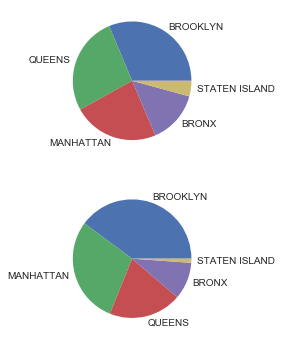

In [9]:
#get number of accidents per km^2 of borough
def getRelFrequency(borough,value):

    #Area of boroughs in km^2
    areaM = 59.1
    areaBR = 180
    areaBX = 110
    areaQ = 280
    areaS = 152 
    
    cases = {
        'MANHATTAN': round(value/areaM,0),
        'BROOKLYN': round(value/areaBR,0),
        'BRONX': round(value/areaBX,0),
        'QUEENS': round(value/areaQ,0),
        'STATEN ISLAND': round(value/areaS,0)
    }
    
    return cases[borough]


#get absolute number of accidents per borough 
dsBorough = df.BOROUGH.value_counts()
print(dsBorough)
dsBoroughRel = df.BOROUGH.value_counts(normalize=True)
print(dsBoroughRel)

#get absolute number of accidents per borough where cyclist injured/killed
dsBoroughCyclist = df2.BOROUGH.value_counts()
print(dsBoroughCyclist)
dsBoroughCyclistRel = df2.BOROUGH.value_counts(normalize=True)
print(dsBoroughCyclistRel)

#plot pie chart to visualize the distribution
plt.subplot(2, 1, 1)
dsBorough.plot.pie(figsize=(6, 6))
plt.ylabel('')

plt.subplot(2, 1, 2)
dsBoroughCyclist.plot.pie(figsize=(6, 6)) 
plt.ylabel('')
plt.show()

   

The results show, that the most accident data points have as borough information Brooklyn (380546 (31%) for the complete data set and 12152 (39%) for the reduced (cyclist injured/killed only) dataset).

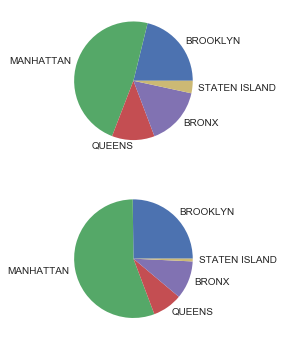

In [10]:
#get number of accidents per km^2 per borough    
dfFrequency = df.BOROUGH.value_counts().rename_axis('unique_values').reset_index(name='counts')
arrFrequency = dfFrequency.values
dictRelFrequency= {arrFrequency[index][0]: getRelFrequency(arrFrequency[index][0],arrFrequency[index][1]) for index in range(len(arrFrequency))}
dsFrequency = pd.Series(data=dictRelFrequency, index=['BROOKLYN', 'MANHATTAN', 'QUEENS','BRONX','STATEN ISLAND'])

#get number of accidents per km^2 per borough where cyclist injured/killed
df2Frequency = df2.BOROUGH.value_counts().rename_axis('unique_values').reset_index(name='counts')
arr2Frequency = df2Frequency.values
dictCyclistRelFrequency= {arr2Frequency[index][0]: getRelFrequency(arr2Frequency[index][0],arr2Frequency[index][1]) for index in range(len(arr2Frequency))}
dsCylistFrequency = pd.Series(data=dictCyclistRelFrequency, index=['BROOKLYN', 'MANHATTAN', 'QUEENS','BRONX','STATEN ISLAND'])

#plot pie chart to visualize the distribution
plt.subplot(2, 1, 1)
dsFrequency.plot.pie(figsize=(6, 6))
plt.ylabel('')

plt.subplot(2, 1, 2)
dsCylistFrequency.plot.pie(figsize=(6, 6)) 
plt.ylabel('')
plt.show()

But if we look at the data points per km^2. We see that the most accident data points have as borough information Manhattan (eg last two pie charts).

Second exercise: We want to analyse the locations of the bike stations.

We search for the area with the highest accident density. For this exercise we concentrate us on the accidents, where a cyclist was injured/killed (only to reduce complexity/runtime).

We want to compare this area to the locations of the bike stations.

In [11]:
# download raw json object
url = 'https://feeds.citibikenyc.com/stations/stations.json'
data = urllib.request.urlopen(url).read().decode()
obj = json.loads(data)
#transform usable data into dict
useDataDict = obj['stationBeanList']
#sample an dict entry to locate the usable information
print(useDataDict[0])

{'id': 72, 'stationName': 'W 52 St & 11 Ave', 'availableDocks': 32, 'totalDocks': 39, 'latitude': 40.76727216, 'longitude': -73.99392888, 'statusValue': 'In Service', 'statusKey': 1, 'availableBikes': 7, 'stAddress1': 'W 52 St & 11 Ave', 'stAddress2': '', 'city': '', 'postalCode': '', 'location': '', 'altitude': '', 'testStation': False, 'lastCommunicationTime': '2016-01-22 04:30:15 PM', 'landMark': ''}


First we look at an item in the dataset to find out, which information is important in regards to our problem.

After that we load the important data into a pandas dataframe.

In [12]:

#load useable date into dict
stationDat = {'ID': [elem['id'] for elem in useDataDict],
              'TOTAL_DOCKS': [elem['totalDocks'] for elem in useDataDict],
              'STATUS': [elem['statusValue'] for elem in useDataDict],
              'LONGITUDE': [elem['longitude'] for elem in useDataDict],
              'LATITUDE' : [elem['latitude'] for elem in useDataDict]}
#load dict into pandas dataframe
dfStat = pd.DataFrame (stationDat, columns = ['ID','TOTAL_DOCKS','STATUS','LONGITUDE','LATITUDE'])

#valide how many stations are not in service to reduce the number of stations
print(dfStat.STATUS.value_counts(dropna=False))

#drop stations not in service
dfStat = dfStat[dfStat.STATUS == 'In Service']

#sample new data to validate that no invalid data points remain
dfStat.dropna(how='any')
print(dfStat.info())
print(dfStat.head())

In Service        504
Not In Service      5
Name: STATUS, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 508
Data columns (total 5 columns):
ID             504 non-null int64
TOTAL_DOCKS    504 non-null int64
STATUS         504 non-null object
LONGITUDE      504 non-null float64
LATITUDE       504 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 23.6+ KB
None
    ID  TOTAL_DOCKS      STATUS  LONGITUDE   LATITUDE
0   72           39  In Service -73.993929  40.767272
1   79           33  In Service -74.006667  40.719116
2   82           27  In Service -74.000165  40.711174
3   83           62  In Service -73.976323  40.683826
4  116           39  In Service -74.001497  40.741776


We see that there are data points for inactive stations. We drop these points from our dataframe and we also drop all the invalid data points.

Now we want to visualize the distribution of these bike stations. For that we create a scatter plot of the stations and integrate this into a heat map of our traffic accident data of NY.

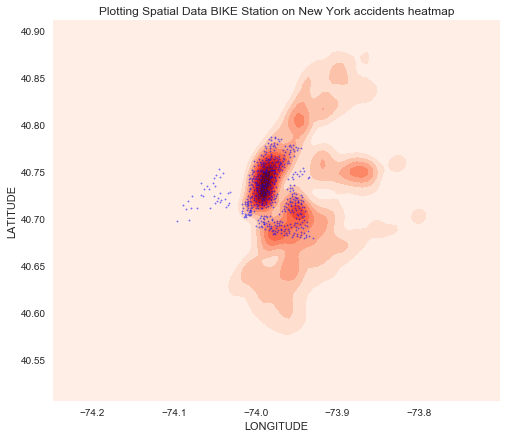

In [13]:
fig, ax = plt.subplots(figsize = (8,7))
sns.kdeplot(df2.LONGITUDE, df2.LATITUDE, cmap="Reds", shade=True)
ax.scatter(dfStat.LONGITUDE, dfStat.LATITUDE, zorder=1, alpha= 0.5, c='b', s=2)
ax.set_title('Plotting Spatial Data BIKE Station on New York accidents heatmap')
ax.set_xlim(df2.LONGITUDE.min(),df2.LONGITUDE.max())
ax.set_ylim(df2.LATITUDE.min(),df2.LATITUDE.max())
plt.show()

We see that a very dense area is Manhattan. There are also a lot of bike stations (blue dots) in this area. To increase the safety we could relocate the stations in this area to a location nearer to the Hudson or the East River. The heatmap shows that fewer traffic accidents occur in this areas. 


Exercise 3: We want to estimate the density of the occured accidents in New York to predict, where an accident is most likely.

Again we use the accident data points, where a cyclist was injured/killed (to reduce complexity/runtime).

To estimate and predict we use an kernel density estimation.

In [14]:
# represent points consistently as (lat, lon)
df2Coordinates = df2[['LATITUDE', 'LONGITUDE']]
coords = df2Coordinates.values

#set up the parameters
#search for a fitted bandwidth
#metric haversine because we use longitude and latitude data 

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 10)},
                    cv=5) # 5-fold cross-validation
grid.fit(coords)
print(grid.best_params_)

#best estimated bandwith 0.01 -> create density estimation model
kde = KernelDensity(metric='haversine', kernel='gaussian', algorithm='ball_tree', bandwidth=0.01).fit(coords)

#get best log scores for the test data eg the accident data points
logprobStat = kde.score_samples(coords)

{'bandwidth': 0.01}


We build our model and get for every traffic accident data point an estimated log density probability. We can now use this estimated density to locate the data points, which are located in the highest and lowest density region.

For that we use empirical quantiles. 

We visualize these areas with a scatter plot.

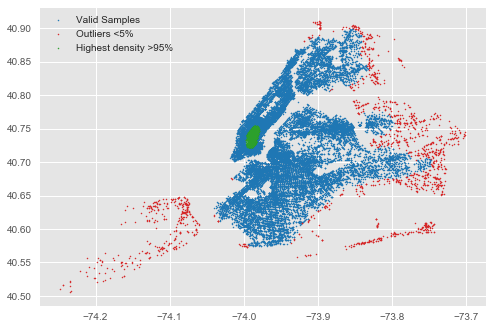

In [15]:
#get a quantil to evaluate which points are isolated eg. outliers
alpha_set = 0.95
tau_kde = mquantiles(logprobStat, 1. - alpha_set)

#get a quantil to evaluate which points create a region with the highest density
alpha_set2 = 0.05
tau_kde2 = mquantiles(logprobStat, 1. - alpha_set2)

outliers = np.argwhere(logprobStat < tau_kde)
outliers = outliers.flatten()
coords_outliers = coords[outliers]

normal_samples = np.argwhere((logprobStat >= tau_kde) & (logprobStat < tau_kde2))
normal_samples = normal_samples.flatten()
coords_valid = coords[normal_samples]

best_samples = np.argwhere(logprobStat >= tau_kde2)
best_samples = best_samples.flatten()
coords_best = coords[best_samples]

with plt.style.context(("seaborn", "ggplot")):
    plt.scatter(coords_valid[:, 1], coords_valid[:, 0], c="tab:blue", label="Valid Samples",s=1)
    plt.scatter(coords_outliers[:, 1], coords_outliers[:, 0], c="tab:red", label="Outliers <5%",s=1)
    plt.scatter(coords_best[:, 1], coords_best[:, 0], c="tab:green", label="Highest density >95%",s=1)
    plt.legend(loc="best")
    plt.show()


As we saw in the heat map before our estimation also shows, that the region with the highest traffic accident density is somewhere in Manhattan.

We now want to get more detailed information on these region. We also want to predict, where an accident is most likely.

For that we search for the data point with the highest estimated density.

In [16]:
#evaluate data and get data point with highest estimated density
maxValue = max(logprobStat)
maxIndex = [i for i, j in enumerate(logprobStat) if j == maxValue]
maxCoords = coords[maxIndex][0]
print('The Coordinate with the highest density probability is at:')
print('Longitude: ' + str(maxCoords[1]) + ' and Latitude: '+ str(maxCoords[0]))

The Coordinate with the highest density probability is at:
Longitude: -73.98859370000001 and Latitude: 40.7371433


We now want to know which bike station is closest to this point.

Therefore we define a distance function (we have to take in account taht we are looking at long and lat data).

In [17]:
def getDistance(lon1,lat1, lon2,lat2):
    # approximate radius of earth in km
    R = 6371.0088
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    #print("Result:", distance)
    return distance

#calculate distances to bike stations from data point with max density. Get bike station with min distance
stationDistDict={stationDat['ID'][index]: getDistance(stationDat['LONGITUDE'][index],stationDat['LATITUDE'][index],maxCoords[1],maxCoords[0]) for index in range(len(stationDat['ID']))}
minDist = min([item for item in stationDistDict.values()])
minId = [key for key in stationDistDict.keys() if stationDistDict[key] == minDist]
print('The closest bike station to our predicted traffic accident point is:' + '\n\n')
print([useDataDict[index] for index in range(len(useDataDict)) if useDataDict[index]['id'] == minId[0]])


The closest bike station to our predicted traffic accident point is:


[{'id': 497, 'stationName': 'E 17 St & Broadway', 'availableDocks': 59, 'totalDocks': 59, 'latitude': 40.73704984, 'longitude': -73.99009296, 'statusValue': 'In Service', 'statusKey': 1, 'availableBikes': 0, 'stAddress1': 'E 17 St & Broadway', 'stAddress2': '', 'city': '', 'postalCode': '', 'location': '', 'altitude': '', 'testStation': False, 'lastCommunicationTime': '2016-01-22 04:31:02 PM', 'landMark': ''}]



Extention Exercise 2

Sample station data and evaluate estimated density for this data. Station locations with highest density can maybe be relocated?


Generell extentions:
    
We can evaluate on which day the accidents occured.
Overall we could get some general traffic data and analyse on which day we have a high vehicle volume and correlate this data with our accident data.

We can also evaluate the exact time of the accidents and correlate this also with general traffic data. 

We can evaluate weather data and data on the road texture to see if this data correlates.


Also we can look at the data I removed in my analysis and try to fill in the missing values.
Here I visualized the data points per borough (here Manhattan) to get a better overview of the accident data points with valid/not missing borough



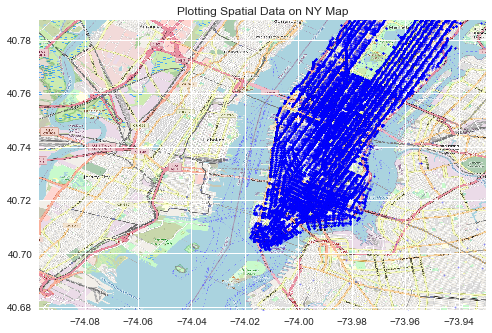

In [18]:
dfM = df[df.BOROUGH == "MANHATTAN"]
dfBX = df[df.BOROUGH == "BRONX"]
dfBR= df[df.BOROUGH == "BROOKLYN"]
dfQ = df[df.BOROUGH == "QUEENS"]
dfS = df[df.BOROUGH == "STATEN ISLAND"]

BBoxM = (dfM.LONGITUDE.min(), dfM.LONGITUDE.max(), dfM.LATITUDE.min(), dfM.LATITUDE.max())
BBoxBX = (dfBX.LONGITUDE.min(), dfBX.LONGITUDE.max(), dfBX.LATITUDE.min(), dfBX.LATITUDE.max())
BBoxBR = (dfBR.LONGITUDE.min(), dfBR.LONGITUDE.max(), dfBR.LATITUDE.min(), dfBR.LATITUDE.max())
BBoxQ = (dfQ.LONGITUDE.min(), dfQ.LONGITUDE.max(), dfQ.LATITUDE.min(), dfQ.LATITUDE.max())
BBoxS = (dfS.LONGITUDE.min(), dfS.LONGITUDE.max(), dfS.LATITUDE.min(), dfS.LATITUDE.max())

'''
print(BBoxM)
print(BBoxBX)
print(BBoxBR)
print(BBoxQ)
print(BBoxS)
'''

BBoxStat = (dfStat.LONGITUDE.min(),dfStat.LONGITUDE.max(),dfStat.LATITUDE.min(),dfStat.LATITUDE.max())
ny_m = plt.imread('data/map.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(dfM.LONGITUDE, dfM.LATITUDE, zorder=1, alpha= 0.4, c='b', s=2)
ax.set_title('Plotting Spatial Data on NY Map')
ax.set_xlim(dfStat.LONGITUDE.min(),dfStat.LONGITUDE.max())
ax.set_ylim(dfStat.LATITUDE.min(),dfStat.LATITUDE.max())
ax.imshow(ny_m, zorder=0, extent = BBoxStat, aspect= 'equal')